<font size="6">**Comparing Toxic Comment Classification models- One Shot, Zero Shot, Few Shot and Fine Tuning**</font> <br>
<font size="5">Yosef Cohen - 312344831

In [23]:
import pandas as pd
import os
from torch.utils.data import Dataset as Dataset
from torch.utils import data as data
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from transformers import pipeline
from tqdm import tqdm
from tqdm import notebook
import openai
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from clearml import Task, Logger, OutputModel

<font size="6">**Define GPU support**</font>

In [24]:
# Define GPU support
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080 Ti


<font size="6">**Show some samples of the data**</font><br>
1. Define path to train csv file.<br>
2. Loading the data from folders.<br>

In [25]:
data_path = os.path.join('data', 'train.csv')
train_data = pd.read_csv(data_path)
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<font size="6">**Count the number of samples of each class**</font>

In [26]:
def count_labels(train_data, title):
    """count the number of samples of each class for the entire dataset and print a distribution chart.

    Parameters
    ----------
    train_data : pandas data frame
        The data we want to count.
    title : string
        The title of the chart.

    Returns
    -------
    None
    """
    plt.figure(figsize=(10,7), dpi=100)
    x_labels = list(train_data.columns[2:])
    x_labels.append('not toxic')
    y_label = train_data.values[:,2:].sum(axis=0)
    y_label = np.append(y_label, (len(train_data) - y_label[0]))
    plt.bar(x_labels, y_label, alpha=0.85)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)

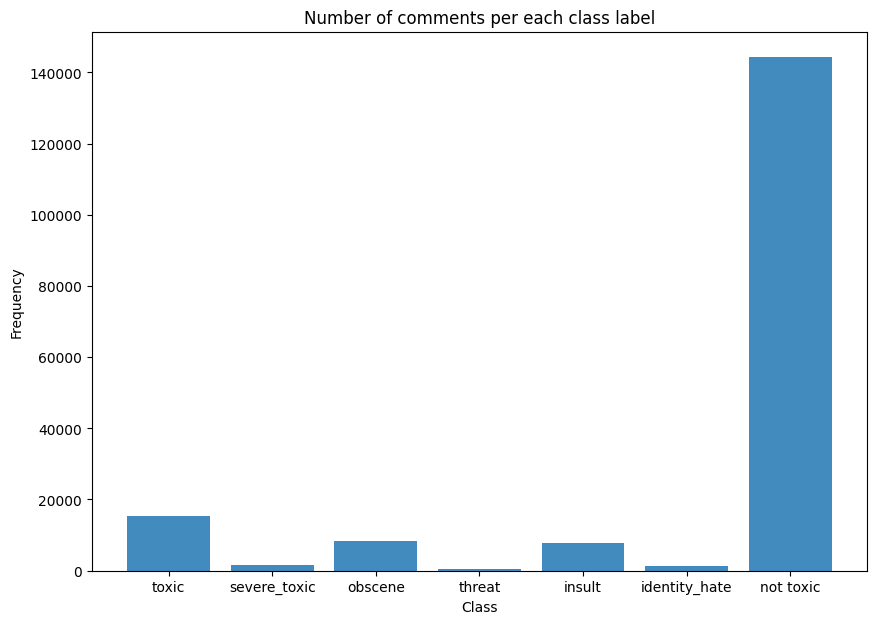

In [27]:
count_labels(train_data, 'Number of comments per each class label')

<font size="6">**Define Toxic Comments Dataset class**</font> <br>

In [28]:
class CommentsDataSet(Dataset):
    """Comments Dataset"""

    def __init__(self, csv_file_dir):
        """
        Arguments:
            csv_file_dir (string): Path to the csv file.

        """
        # read csv file and load data
        self.df_data = pd.read_csv(csv_file_dir)
        self.x_train = self.df_data['comment_text']
        self.y_train = self.df_data[self.df_data.columns[2:]]
    
    def __len__(self):
        """
        get dataset length.

        """
        return len(self.x_train)
    
    def __getitem__(self, index):
        """
        Arguments:
            index (int): comment number.

        """
        return self.x_train[index], np.array(self.y_train.iloc[index])
    
    def labels(self):
        """
        get dataset labels.

        """
        return self.df_data.columns[2:].to_list()



<font size="6">**Loading the dataset**</font><br>
1. Split the dataset to training and few shot dataset for generating examples.<br>
2. 200 samples for testing.
3. Encapsulate the data into dataloader form.

In [29]:
train_dataset_full = CommentsDataSet(data_path)
num_samples = 200

dataset_size = len(train_dataset_full)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

# make balance test dataset
toxic_indices = []
non_toxic_indices = []
few_shot_indices = dataset_indices.copy()

for i in dataset_indices:
    _, labels = train_dataset_full.__getitem__(i)
    if len(toxic_indices) < num_samples//2:
        if labels.sum() > 0:
            toxic_indices.append(i)
            few_shot_indices.remove(i)
    
    if len(non_toxic_indices) < num_samples//2:
        if labels.sum() == 0:
            non_toxic_indices.append(i)
            few_shot_indices.remove(i)

indices = toxic_indices + non_toxic_indices
np.random.shuffle(indices)

batch_size = 1
test_sampler = data.SubsetRandomSampler(indices)
train_dataloader = data.DataLoader(train_dataset_full, batch_size=batch_size, sampler=test_sampler, shuffle=False)

<font size="6">**GPT-3**</font> <br>
<font size="5">Zero Shot learning.

In [227]:
openai.api_key = ("your key")

<font size="6">**Zero Shot classify toxic comment function**</font><br>

In [228]:
def zero_shot_classify_toxic_comment(comment, labels):
    """Generate prompt to GPT-3 OpenAI api based on comment and the optional labels.

    Parameters
    ----------
    comment : string
        The comment we want to classify.
    labels : list of strings
        The optional labels.

    Returns
    -------
    answer : string
        The chosen labels.
    """
    prompt = f"Classify the following comment as toxic or not and the types of toxicity: \n\n {comment} \n\nLabels: {labels}"
    response = openai.Completion.create(
        prompt=prompt,
        model="text-davinci-003",
        temperature=0.3,
        max_tokens=256
    )
    return response.choices[0].text.strip()


<font size="6">**Show example of comment, answer and true labels**</font><br>

In [230]:
comment, _ = train_dataset_full.__getitem__(600)
classification = zero_shot_classify_toxic_comment(comment, train_dataset_full.labels())
print(f'Comment:\n{comment}\n###')
print(f"The comment is classified as: {classification}\n###")
print(f'True labels:\n{train_data.iloc[600].iloc[2:]}')

Comment:
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you
###
The comment is classified as: Toxic, Severe Toxic, Threat
###
True labels:
toxic            1
severe_toxic     0
obscene          0
threat           1
insult           0
identity_hate    0
Name: 600, dtype: object


<font size="6">**Convert the predicted labels to array of 0 and 1**</font><br>

In [30]:
def convert_pred_to_array(classification, classes):
    """Convert the predicted labels to array of 0 and 1.

    Parameters
    ----------
    classification : string
        The classified labels.
    classes : list of strings
        The optional labels.

    Returns
    -------
    pred_array : numpy array
        Predicted labels array of 0 and 1.
    """
    pred_array = np.zeros(len(classes),dtype=int)
    
    if 'not toxic' not in classification.lower():
        for label in classes:
            if label in classification.lower().replace(' ', '_'):
                pred_array[classes.index(label)] = 1
    
    return pred_array

<font size="6">**Classification function for Zero Shot**</font><br>

In [31]:
def classify(model, train_dataloader):
    """Classify the comments.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds = []
    targets = []
    num_samples = len(train_dataloader)
    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        classification = model(comment, train_dataloader.dataset.labels())
        pred = convert_pred_to_array(classification, train_dataloader.dataset.labels())
        preds.append(pred)
        targets.append(labels.numpy())
    
    return preds, targets

<font size="6">**Classify with Zero Shot**</font><br>

In [234]:
ZS_gpt3_preds, ZS_gpt3_targets = classify(zero_shot_classify_toxic_comment, train_dataloader)

100%|██████████| 200/200 [05:59<00:00,  1.80s/it]


In [237]:
# save the results
np.save('preds\ZS_gpt3_preds.npy', ZS_gpt3_preds)
np.save('preds\ZS_gpt3_targets.npy', ZS_gpt3_targets)

<font size="6">**Accuracy function**</font><br>

In [21]:
def Accuracy(preds, targets):
    """Calculate accuracy.

    Parameters
    ----------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.

    Returns
    -------
    accuracy : float
        Accuracy.
    """
    accuracy = 0
    for i in range(len(preds)):
        if np.array_equal(np.array(preds)[i] ,np.array(targets).squeeze(1)[i]) == True:
            accuracy += 1

    accuracy = accuracy / len(preds)

    return accuracy

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [33]:
accuracy = Accuracy(ZS_gpt3_preds, ZS_gpt3_targets)
print(f'Accuracy: {accuracy}')
AUC_score = roc_auc_score(ZS_gpt3_targets.squeeze(), ZS_gpt3_preds)
print(f'AUC score: {AUC_score}\n')
print(classification_report(np.array(ZS_gpt3_targets).squeeze(1), np.array(ZS_gpt3_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.485
AUC score: 0.7201714674376918

               precision    recall  f1-score   support

        toxic       0.91      0.76      0.83        97
 severe_toxic       0.16      0.71      0.26        14
      obscene       0.66      0.69      0.67        55
       threat       0.05      0.50      0.08         6
       insult       0.49      0.78      0.60        49
identity_hate       0.09      0.60      0.16        10

    micro avg       0.41      0.73      0.52       231
    macro avg       0.39      0.67      0.43       231
 weighted avg       0.66      0.73      0.66       231
  samples avg       0.17      0.38      0.22       231



<font size="6">**GPT-3**</font> <br>
<font size="5">One Shot learning.

<font size="6">**One Shot classify toxic comment function**</font><br>

In [238]:
def one_shot_classify_toxic_comment(comment, labels, example):
    """Generate prompt to GPT-3 OpenAI api based on comment, optional labels and one example.

    Parameters
    ----------
    comment : string
        The comment we want to classify.
    labels : list of strings
        The optional labels.
    example : string
        comment with true labels.

    Returns
    -------
    answer : string
        The chosen labels.
    """
    prompt = f"Classify the following comment as toxic or not and the types of toxicity. \nWith the following labels: {labels} \n\nFor example:\n{example} \n\nComment to classify:\n{comment}"
    response = openai.Completion.create(
        prompt=prompt,
        model="text-davinci-003",
        temperature=0.3,
        max_tokens=256
    )
    return response.choices[0].text.strip()

<font size="6">**Generate example function**</font><br>

In [255]:
def generate_example(train_dataset, index):
    """Generate comment example with the true labels.

    Parameters
    ----------
    train_dataset : dataset
        The comments dataset.
    index : int
        The comment index.

    Returns
    -------
    example : string
        comment with true labels.
    """
    labels = train_dataset.labels()
    example_comment , tar = train_dataset.__getitem__(index)
    example_labels = 'Labels:'
    for i in range(len(tar)):
        if tar[i] == 1:
            example_labels += f' {labels[i]},'

    if example_labels == 'Labels:':
        example_labels += ' not toxic.'
    else:
        example_labels = list(example_labels)
        example_labels[-1] = '.'
        example_labels = "".join(example_labels)

    example = f'Comment: {example_comment}\n{example_labels}'
    
    return example

<font size="6">**Show example of prompt and answer**</font><br>

In [244]:
example = generate_example(train_dataset_full, 6)
labels = train_dataset_full.labels()
comment , _ = train_dataset_full.__getitem__(602)
print(f"Classify the following comment as toxic or not and the types of toxicity. \nWith the following labels: {labels} \n\nFor example:\n{example} \n\nComment to classify:\n{comment}")
one_shot_classify_toxic_comment(comment, labels, example)

Classify the following comment as toxic or not and the types of toxicity. 
With the following labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 

For example:
Comment: COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Labels: toxic, severe_toxic, obscene, insult. 

Comment to classify:
Are you fucker mother fucker have nothing to do but block University computers. Go and suck cocks


'Toxic, severe_toxic, obscene, insult, identity_hate.'

<font size="6">**Classification function for One Shot**</font><br>

In [246]:
def classify_OS(model, train_dataloader, example):
    """Classify the comments.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.
    example : string
        comment with true labels.

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds = []
    targets = []
    num_samples = len(train_dataloader)
    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        classification = model(comment, train_dataloader.dataset.labels(), example)
        pred = convert_pred_to_array(classification, train_dataloader.dataset.labels())
        preds.append(pred)
        targets.append(labels.numpy())
    
    return preds, targets

<font size="6">**Classify with One Shot**</font><br>

In [247]:
example = generate_example(train_dataset_full, 6)
OS_gpt3_preds, OS_gpt3_targets = classify_OS(one_shot_classify_toxic_comment, train_dataloader, example)

100%|██████████| 200/200 [04:36<00:00,  1.38s/it]


In [270]:
# save the results
np.save('preds\OS_gpt3_preds.npy', OS_gpt3_preds)
np.save('preds\OS_gpt3_targets.npy', OS_gpt3_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [36]:
OS_gpt3_accuracy = Accuracy(OS_gpt3_preds, OS_gpt3_targets)
print(f'Accuracy: {OS_gpt3_accuracy}')
AUC_score = roc_auc_score(OS_gpt3_targets.squeeze(), OS_gpt3_preds)
print(f'AUC score: {AUC_score}\n')
print(classification_report(np.array(OS_gpt3_targets).squeeze(1), np.array(OS_gpt3_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.525
AUC score: 0.8416608672121105

               precision    recall  f1-score   support

        toxic       0.94      0.70      0.80        97
 severe_toxic       0.27      0.86      0.41        14
      obscene       0.85      0.51      0.64        55
       threat       0.50      1.00      0.67         6
       insult       0.54      0.80      0.64        49
identity_hate       0.38      0.80      0.52        10

    micro avg       0.63      0.70      0.66       231
    macro avg       0.58      0.78      0.61       231
 weighted avg       0.76      0.70      0.69       231
  samples avg       0.23      0.31      0.25       231



<font size="6">**GPT-3**</font> <br>
<font size="5">Few Shot learning.

<font size="6">**Generate examples function**</font><br>

In [416]:
def generate_examples(train_dataset_full, few_shot_indices, num_ex):
    """Generate comment examples with the true labels.

    Parameters
    ----------
    train_dataset_full : dataset
        The comments dataset.
    few_shot_indices : list
        indexes
    num_ex : int
        The number of examples to generate.

    Returns
    -------
    examples : string
        comments with true labels.
    """
    examples_toxic = []
    examples_not_toxic = []
    examples_list = []
    for i in few_shot_indices:
        ex = generate_example(train_dataset_full, i)
        if 'not toxic' in ex:
            if len(examples_not_toxic) < num_ex//2:
                examples_not_toxic.append(ex)
        else:
            if len(examples_toxic) < num_ex//2:
                examples_toxic.append(ex)

    examples_list = examples_toxic + examples_not_toxic
    
    examples = ''
    for ex in examples_list:
        examples += f'{ex}\n\n'
    
    return examples

<font size="6">**Few Shot classify toxic comment function**</font><br>

In [262]:
def few_shot_classify_toxic_comment(comment, labels, examples):
    """Generate prompt to GPT-3 OpenAI api based on comment, optional labels and one examples.

    Parameters
    ----------
    comment : string
        The comment we want to classify.
    labels : list of strings
        The optional labels.
    examples : string
        comments with true labels.

    Returns
    -------
    answer : string
        The chosen labels.
    """
    prompt = f"Classify the following comment as toxic or not and the types of toxicity. \nWith the following labels: {labels} \n\nFor example:\n{examples}Comment to classify:\n{comment}\n"
    response = openai.Completion.create(
        prompt=prompt,
        model="text-davinci-003",
        temperature=0.3,
        max_tokens=256
    )
    
    return response.choices[0].text.strip()

<font size="6">**Show example of prompt and answer**</font><br>

In [263]:
examples = generate_examples(train_dataset_full, few_shot_indices, 10)
labels = train_dataloader.dataset.labels()
comment , _ = train_dataset_full.__getitem__(600)
print(f"Classify the following comment as toxic or not and the types of toxicity. \nWith the following labels: {labels} \n\nFor example:\n{examples}Comment to classify:\n{comment}\n")
few_shot_classify_toxic_comment(comment, labels, examples)

Classify the following comment as toxic or not and the types of toxicity. 
With the following labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 

For example:
Comment: Here is the problem with your argument.  As you stated on IRC:
This isn't about deletionism or inclusionism, it's about you being an asshole to people who disagree with you.
Labels: toxic.

Comment: IT IS OBVIOUS YOU DO NOT GIVE A CRAP ABOUT ACTUALLY HAVING A NEUTRAL ENCYCLOPEDIA OR BOTHERING TO CHECK THE FUCKING SOURCES.
Labels: toxic, obscene.

Comment: Silly is you who supports his wife and kids at the expense of laundering something that is poisonous to other families. Your family must be really proud of you. Your recent comments only further prove that you are a bought-out shill, who has no dignity and will launder anything for money... to support his family. But there are other, more dignifying, means to put your ph.d towards, mr. 'medicinal' chemist. I wonder why you emphasize 'medi

'Labels: toxic, threat.'

<font size="6">**Classification function for Few Shot**</font><br>

In [266]:
def classify_FS(model, train_dataloader, train_dataset_full, few_shot_indices):
    """Classify the comments with random examples.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.
    train_dataset_full : dataset
        The comments dataset.
    few_shot_indices : list
        indexes

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds = []
    targets = []
    num_samples = len(train_dataloader)
    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        examples = generate_examples(train_dataset_full, few_shot_indices, 10)
        classification = model(comment, train_dataloader.dataset.labels(), examples)
        pred = convert_pred_to_array(classification, train_dataloader.dataset.labels())
        preds.append(pred)
        targets.append(labels.numpy())
    
    return preds, targets

<font size="6">**Classify with Few Shot**</font><br>

In [267]:
FS_gpt3_preds, FS_gpt3_targets = classify_FS(few_shot_classify_toxic_comment, train_dataloader, train_dataset_full, few_shot_indices)

100%|██████████| 200/200 [16:45<00:00,  5.03s/it]


In [269]:
# save the results
np.save('preds\FS_gpt3_preds.npy', FS_gpt3_preds)
np.save('preds\FS_gpt3_targets.npy', FS_gpt3_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [38]:
FS_gpt3_accuracy = Accuracy(FS_gpt3_preds, FS_gpt3_targets)
print(f'Accuracy: {FS_gpt3_accuracy}')
AUC_score = roc_auc_score(FS_gpt3_targets.squeeze(), FS_gpt3_preds)
print(f'AUC score: {AUC_score}\n')
print(classification_report(np.array(FS_gpt3_targets).squeeze(1), np.array(FS_gpt3_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.495
AUC score: 0.7890931485732678

               precision    recall  f1-score   support

        toxic       0.84      0.95      0.89        97
 severe_toxic       0.27      0.50      0.35        14
      obscene       0.86      0.45      0.60        55
       threat       0.26      1.00      0.41         6
       insult       0.47      0.82      0.59        49
identity_hate       0.29      0.50      0.37        10

    micro avg       0.60      0.76      0.67       231
    macro avg       0.50      0.70      0.54       231
 weighted avg       0.69      0.76      0.69       231
  samples avg       0.33      0.39      0.33       231



<font size="6">**T5**</font> <br>
<font size="5">Zero Shot learning.

In [47]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

nS_T5_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small").to(device)
nS_T5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

nS_T5_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

<font size="6">**Show example of comment, answer and true labels**</font><br>

In [48]:
sequence_to_classify ,f = train_dataset_full.__getitem__(600)
prompt =f"Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].\n\nPredict one or more labels for the comment: {sequence_to_classify}"
print(prompt)
inputs = nS_T5_tokenizer(prompt, return_tensors="pt").to(device)
outputs = nS_T5_model.generate(**inputs, max_new_tokens = 1024)
ans = nS_T5_tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(f'\nprediction: {ans}')
print(f'\nTrue labels:\n{train_data.iloc[600].iloc[2:]}')

Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].

Predict one or more labels for the comment: I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you

prediction: ['[toxic, severe toxic, obscene, threat, insult, identity hate']

True labels:
toxic            1
severe_toxic     0
obscene          0
threat           1
insult           0
identity_hate    0
Name: 600, dtype: object


<font size="6">**T5 Zero Shot classify toxic comment function**</font><br>

In [49]:
def Zero_shot_classify_toxic_comment_T5(comment):
    """Generate prompt to T5 OpenAI api based on comment, optional labels and one example.

    Parameters
    ----------
    comment : string
        The comment we want to classify.

    Returns
    -------
    answer : string
        The model.
    """
    prompt = f"Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].\n\nPredict one or more labels for the comment: {comment}"
    inputs = nS_T5_tokenizer(prompt, return_tensors="pt").to(device)
    outputs = nS_T5_model.generate(**inputs, max_new_tokens = 1024)
    answer = nS_T5_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return answer[0]

<font size="6">**Classification function for T5 Zero Shot**</font><br>

In [50]:
def classify_ZS_T5(model, train_dataloader):
    """Classify the comments.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds = []
    targets = []
    num_samples = len(train_dataloader)
    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        classification = model(comment)
        pred = convert_pred_to_array(classification, train_dataloader.dataset.labels())
        preds.append(pred)
        targets.append(labels.numpy())
    
    return preds, targets

<font size="6">**Classify with Zero Shot**</font><br>

In [53]:
ZS_T5_preds, ZS_T5_targets = classify_ZS_T5(Zero_shot_classify_toxic_comment_T5, train_dataloader)

100%|██████████| 200/200 [00:20<00:00,  9.83it/s]


In [55]:
# save the results
np.save('preds\ZS_T5_preds.npy', ZS_T5_preds)
np.save('preds\ZS_T5_targets.npy', ZS_T5_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [54]:
ZS_T5_accuracy = Accuracy(ZS_T5_preds, ZS_T5_targets)
print(f'Accuracy: {ZS_T5_accuracy}')
y_true = np.array(ZS_T5_targets).reshape((-1, 6))
y_preds = np.array(ZS_T5_preds).reshape((-1, 6))
AUC_score = roc_auc_score(y_true, y_preds)
print(f'Test AUC score: {AUC_score}\n')
print(classification_report(np.array(ZS_T5_targets).squeeze(1), np.array(ZS_T5_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.245
Test AUC score: 0.5316233042906364

               precision    recall  f1-score   support

        toxic       0.57      0.75      0.65        96
 severe_toxic       0.01      0.25      0.02         4
      obscene       0.28      0.69      0.39        45
       threat       0.01      0.50      0.02         2
       insult       0.29      0.76      0.42        42
identity_hate       0.04      0.57      0.07         7

    micro avg       0.21      0.72      0.33       196
    macro avg       0.20      0.59      0.26       196
 weighted avg       0.41      0.72      0.50       196
  samples avg       0.15      0.35      0.18       196



<font size="6">**T5**</font> <br>
<font size="5">One Shot learning.

<font size="6">**Generate example function T5**</font><br>

In [56]:
def generate_example_T5(train_dataset, index):
    """Generate comment example with the true labels.

    Parameters
    ----------
    train_dataset : dataset
        The comments dataset.
    index : int
        The comment index.

    Returns
    -------
    example : string
        comment with true labels.
    """
    labels = train_dataset.labels()
    example_comment , tar = train_dataset.__getitem__(index)
    example_labels = 'The classification of the comment is:'
    for i in range(len(tar)):
        if tar[i] == 1:
            labels[i] = labels[i].replace('_', ' ')
            example_labels += f' {labels[i]},'

    if example_labels == 'The classification of the comment is:':
        example_labels += ' not toxic.'
    else:
        example_labels = list(example_labels)
        example_labels[-1] = '.'
        example_labels = "".join(example_labels)

    example = f'For example, comment:\"{example_comment}\". {example_labels}'
    
    return example

<font size="6">**Show example of comment, answer and true labels**</font><br>

In [410]:
sequence_to_classify ,f = train_dataset_full.__getitem__(600)
example = generate_example_T5(train_dataset_full, 6)
prompt =f"Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].\n\n{example}\n\nPredict one or more labels for the comment: {sequence_to_classify}"
print(prompt)
inputs = nS_T5_tokenizer(prompt, return_tensors="pt").to(device)
outputs = nS_T5_model.generate(**inputs, max_new_tokens = 1024)
ans = nS_T5_tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(f'\nprediction: {ans}')
print(f'\nTrue labels:\n{train_data.iloc[600].iloc[2:]}')

Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].

For example, comment:"COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK". The classification of the comment is: toxic, severe toxic, obscene, insult.

Predict one or more labels for the comment: I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you

prediction: ['[toxic, severe toxic, obscene, threat, insult, identity hate']

True labels:
toxic            1
severe_toxic     0
obscene          0
threat           1
insult           0
identity_hate    0
Name: 600, dtype: object


<font size="6">**T5 One Shot classify toxic comment function**</font><br>

In [57]:
def one_shot_classify_toxic_comment_T5(comment, example):
    """Generate prompt to T5 OpenAI api based on comment, optional labels and one example.

    Parameters
    ----------
    comment : string
        The comment we want to classify.
    example : string
        comment with true labels.

    Returns
    -------
    answer : string
        The chosen labels.
    """
    prompt = f"Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].\n\n{example}\n\nPredict one or more labels for the comment: {comment}"
    inputs = nS_T5_tokenizer(prompt, return_tensors="pt").to(device)
    outputs = nS_T5_model.generate(**inputs, max_new_tokens = 1024)
    answer = nS_T5_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return answer[0]

<font size="6">**Classification function for T5 One Shot**</font><br>

In [58]:
def classify_nS_T5(model, train_dataloader, example):
    """Classify the comments.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.
    example : string
        comment with true labels.

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds = []
    targets = []
    num_samples = len(train_dataloader)
    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        classification = model(comment, example)
        pred = convert_pred_to_array(classification, train_dataloader.dataset.labels())
        preds.append(pred)
        targets.append(labels.numpy())
    
    return preds, targets

<font size="6">**Classify with One Shot**</font><br>

In [446]:
example = generate_example_T5(train_dataset_full, 6)
OS_T5_preds, OS_T5_targets = classify_nS_T5(one_shot_classify_toxic_comment_T5, train_dataloader, example)

100%|██████████| 200/200 [00:21<00:00,  9.21it/s]


In [447]:
# save the results
np.save('preds\OS_T5_preds.npy', OS_T5_preds)
np.save('preds\OS_T5_targets.npy', OS_T5_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [60]:
OS_T5_accuracy = Accuracy(OS_T5_preds, OS_T5_targets)
print(f'Accuracy: {OS_T5_accuracy}')
y_true = np.array(OS_T5_targets).reshape((-1, 6))
y_preds = np.array(OS_T5_preds).reshape((-1, 6))
AUC_score = roc_auc_score(y_true, y_preds)
print(f'Test AUC score: {AUC_score}\n')
print(classification_report(np.array(OS_T5_targets).squeeze(1), np.array(OS_T5_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.19
Test AUC score: 0.6291673298322215

               precision    recall  f1-score   support

        toxic       0.55      0.87      0.67        93
 severe_toxic       0.07      1.00      0.14        11
      obscene       0.31      0.84      0.45        55
       threat       0.02      1.00      0.04         2
       insult       0.32      0.89      0.47        53
identity_hate       0.05      0.88      0.09         8

    micro avg       0.23      0.87      0.37       222
    macro avg       0.22      0.91      0.31       222
 weighted avg       0.39      0.87      0.52       222
  samples avg       0.18      0.42      0.23       222



<font size="6">**T5**</font> <br>
<font size="5">Few Shot learning.

<font size="6">**Generate T5 examples function**</font><br>

In [14]:
def generate_examples_T5(train_dataset_full, few_shot_indices, num_ex):
    """Generate comment examples with the true labels.

    Parameters
    ----------
    train_dataset_full : dataset
        The comments dataset.
    few_shot_indices : list
        indexes
    num_ex : int
        The number of examples to generate.

    Returns
    -------
    examples : string
        comments with true labels.
    """
    examples_toxic = []
    examples_not_toxic = []
    examples_list = []
    for i in few_shot_indices:
        ex = generate_example_T5(train_dataset_full, i)
        if 'not toxic' in ex:
            if len(examples_not_toxic) < num_ex//2:
                examples_not_toxic.append(ex)
        else:
            if len(examples_toxic) < num_ex//2:
                examples_toxic.append(ex)

    examples_list = examples_toxic + examples_not_toxic
    
    examples = ''
    for ex in examples_list:
        examples += f'{ex}\n\n'
    
    return examples

<font size="6">**T5 Few Shot classify toxic comment function**</font><br>

In [15]:
def few_shot_classify_toxic_comment_T5(comment, examples):
    """Generate prompt to T5 OpenAI api based on comment, optional labels and examples.

    Parameters
    ----------
    comment : string
        The comment we want to classify.
    labels : list of strings
        The optional labels.
    example : string
        comment with true labels.

    Returns
    -------
    answer : string
        The chosen labels.
    """
    prompt = f"Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].\n\n{examples}\n\nPredict one or more labels for the comment: {comment}"
    inputs = nS_T5_tokenizer(prompt, return_tensors="pt").to(device)
    outputs = nS_T5_model.generate(**inputs, max_new_tokens = 20)
    answer = nS_T5_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return answer[0]

<font size="6">**Show example of comment, answer and true labels**</font><br>

In [457]:
sequence_to_classify ,f = train_dataset_full.__getitem__(600)
examples = generate_examples_T5(train_dataset_full, few_shot_indices, 10)
prompt =f"Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].\n\n{examples}\n\nPredict one or more labels for the comment: {sequence_to_classify}"
print(prompt)
# inputs = nS_BART_tokenizer(prompt, return_tensors="pt").to(device)
# outputs = nS_BART_model.generate(**inputs, max_new_tokens = 20)
# ans = nS_BART_tokenizer.batch_decode(outputs, skip_special_tokens=True)
ans = few_shot_classify_toxic_comment_T5(sequence_to_classify, examples)
print(f'\nprediction: {ans}')
print(f'\nTrue labels:\n{train_data.iloc[600].iloc[2:]}')

Classify a comment as toxic or not and choose the types of toxicity from the following labels: [toxic, severe toxic, obscene, threat, insult, identity hate or not toxic].

For example, comment:"Paid fukkin scumbag - Kleargear 

This fukker has protected William Franklin Bermender since day fukkin one.

INVESTIGATE this paid mole and right fukkin now!!!". The classification of the comment is: toxic, obscene, insult.

For example, comment:"P4k 

If what you do in Wikipedia is delete things people worked on, why in the world are you logged on to wikipedia. Say, do you delete things for...enjoyment? Or do you delete things for a good reason? How would you feel if I went to one page you did and deleted the whole thing and wrote on it FUCK YOU!!!! How would you feel?". The classification of the comment is: toxic, obscene, insult.

For example, comment:"Horrible horrible... 

...little shit, That's what you are. Horrible horrible....

...things are going to happen to you, you meddling little 

<font size="6">**Classify with Few Shot**</font><br>

In [18]:
examples = generate_examples_T5(train_dataset_full, few_shot_indices, 10)
FS_T5_preds, FS_T5_targets = classify_nS_T5(few_shot_classify_toxic_comment_T5, train_dataloader, examples)

100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


In [19]:
# save the results
np.save('preds\FS_T5_preds.npy', FS_T5_preds)
np.save('preds\FS_T5_targets.npy', FS_T5_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [62]:
FS_T5_accuracy = Accuracy(FS_T5_preds, FS_T5_targets)
print(f'Accuracy: {FS_T5_accuracy}')
y_true = np.array(FS_T5_targets).reshape((-1, 6))
y_preds = np.array(FS_T5_preds).reshape((-1, 6))
AUC_score = roc_auc_score(y_true, y_preds)
print(f'Test AUC score: {AUC_score}\n')
print(classification_report(np.array(FS_T5_targets).squeeze(1), np.array(FS_T5_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.125
Test AUC score: 0.49973170635968334

               precision    recall  f1-score   support

        toxic       0.46      1.00      0.63        92
 severe_toxic       0.00      0.00      0.00        10
      obscene       0.27      1.00      0.42        53
       threat       0.00      0.00      0.00         2
       insult       0.26      1.00      0.41        51
identity_hate       0.00      0.00      0.00         9

    micro avg       0.33      0.90      0.48       217
    macro avg       0.16      0.50      0.24       217
 weighted avg       0.32      0.90      0.47       217
  samples avg       0.33      0.47      0.36       217



<font size="6">**BART**</font> <br>
<font size="5">Zero Shot learning.<br>
Using "facebook/bart-large-mnli" model for Zero shot classification

In [17]:
ZS_BART = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [19]:
pre_path = os.path.join( 'preds', 'ZS_BART_preds.npy')
ZS_BART_preds = np.load(pre_path)
tar_path = os.path.join( 'preds', 'ZS_BART_targets.npy')
ZS_BART_targets = np.load(tar_path)

<font size="6">**Show example of comment, answer and true labels**</font><br>

In [7]:
sequence_to_classify ,_ = train_dataset_full.__getitem__(600)
candidate_labels = train_dataset_full.labels()
display(ZS_BART(sequence_to_classify, candidate_labels, multi_label=True))
print(f'\nTrue labels:\n{train_data.iloc[600].iloc[2:]}')

{'sequence': "I'm also a sock puppet of this account...SUPRISE!!\n-sincerely,\n            The man that will track you down from the Internet and kill you",
 'labels': ['threat',
  'obscene',
  'toxic',
  'severe_toxic',
  'identity_hate',
  'insult'],
 'scores': [0.9347251653671265,
  0.925753653049469,
  0.754010796546936,
  0.31084638833999634,
  0.16724631190299988,
  0.04525650665163994]}


True labels:
toxic            1
severe_toxic     0
obscene          0
threat           1
insult           0
identity_hate    0
Name: 600, dtype: object


<font size="6">**Convert the predicted labels to array of 0 and 1**</font><br>

In [9]:
def convert_pred_to_array_ZS_BART(classification, train_dataloader):
    scores = classification['scores'].copy()
    labels_pred = classification['labels'].copy()
    labels = train_dataloader.dataset.labels()
    pred = np.zeros(len(scores), dtype=np.int64)

    for j in range(len(scores)):
        if scores[j] > 0.5:
            pred[labels.index(labels_pred[j])] = 1
    
    return pred

<font size="6">**Classification function for BART Zero Shot**</font><br>

In [8]:
def classify_ZS_BART(model, train_dataloader):
    """Classify the comments.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds = []
    targets = []
    num_samples = len(train_dataloader)
    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        classification = model(comment, train_dataloader.dataset.labels(), multi_label=True)
        pred = convert_pred_to_array_ZS_BART(classification, train_dataloader)
        preds.append(pred)
        targets.append(labels.numpy())
    
    return preds, targets

<font size="6">**Classify with BART Zero Shot**</font><br>

In [10]:
ZS_BART_preds, ZS_BART_targets = classify_ZS_BART(ZS_BART, train_dataloader)

100%|██████████| 200/200 [04:13<00:00,  1.27s/it]


In [ ]:
# save the results
np.save('preds\ZS_BART_preds.npy', ZS_BART_preds)
np.save('preds\ZS_BART_targets.npy', ZS_BART_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [27]:
ZS_BART_accuracy = Accuracy(ZS_BART_preds, ZS_BART_targets)
print(f'Accuracy: {ZS_BART_accuracy}')
AUC_score = roc_auc_score(ZS_BART_targets.squeeze(), ZS_BART_preds)
print(f'AUC score: {AUC_score}\n')
print(classification_report(np.array(ZS_BART_targets).squeeze(1), np.array(ZS_BART_preds), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.22
AUC score: 0.7146944306386477

               precision    recall  f1-score   support

        toxic       0.69      0.89      0.78        97
 severe_toxic       0.13      0.86      0.22        14
      obscene       0.44      0.93      0.59        55
       threat       0.03      0.83      0.07         6
       insult       0.39      1.00      0.56        49
identity_hate       0.21      0.70      0.33        10

    micro avg       0.33      0.91      0.48       231
    macro avg       0.32      0.87      0.42       231
 weighted avg       0.50      0.91      0.62       231
  samples avg       0.21      0.45      0.27       231



<font size="6">**BART**</font> <br>
<font size="5">One Shot learning.<br>
fine tune classification model with one sample

In [28]:
from transformers import BartTokenizer, BartForSequenceClassification, BartConfig

config = BartConfig.from_pretrained(pretrained_model_name_or_path="facebook/bart-large", num_labels=6)
BART_tokenizer_OS = BartTokenizer.from_pretrained("facebook/bart-large")
Bart_model_OS = BartForSequenceClassification.from_pretrained("facebook/bart-large", config=config).to(device)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<font size="6">**Train the model with one example for one epoch**</font> <br>

In [29]:
epochs = 1
learning_rate = 2e-3
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(Bart_model_OS.parameters(), lr=learning_rate)
max_length = 60

for epoch in tqdm(range(epochs), desc='Training process'):
    comments, labels = train_dataset_full.__getitem__(6)
    inputs = BART_tokenizer_OS(text=comments, return_tensors="pt", padding=True, truncation=True,  max_length=60).to(device)
    labels = torch.unsqueeze(torch.tensor(labels, dtype=torch.float32), 0).to(device)

    # Forward pass
    output = Bart_model_OS(**inputs)
    loss = loss_func(output.logits, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training process: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


<font size="6">**Classification function for BART n Shot**</font><br>

In [11]:
def Accuracy_BART(preds_list, labels_list):
    accuracy = 0
    for i in range(len(preds_list)):
        accuracy += np.count_nonzero(((preds_list[i]  == labels_list[i]).astype(int).sum(axis=1)) == 6)

    accuracy = accuracy / (len(preds_list) * len(preds_list[0]))

    return accuracy

def classify_nS_BART(model, tokenizer, train_dataloader):
    """Classify the comments.

    Parameters
    ----------
    model : the model function.
        Zero shot model.
    train_dataloader : pytorch dataloader
        The comments.

    Returns
    -------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.
    """
    preds_list = []
    targets = []
    num_samples = len(train_dataloader)

    for i, (comment, labels) in tqdm(enumerate(train_dataloader), total=num_samples):
        inputs = tokenizer(text=comment, return_tensors="pt", padding=True, truncation=True,  max_length=60).to(device)
        labels = labels.type(torch.float32)
        targets.append(labels.numpy())

        with torch.no_grad():
            test_output = model(**inputs)
            
        preds = torch.sigmoid(test_output.logits)
        preds = (preds > 0.5).float()
        preds_list.append(preds.to('cpu').numpy())
    
    return preds_list, targets

<font size="6">**Classify with BART One Shot**</font><br>

In [31]:
OS_BART_preds, OS_BART_targets = classify_nS_BART(Bart_model_OS, BART_tokenizer_OS, train_dataloader)

100%|██████████| 200/200 [00:02<00:00, 72.12it/s]


In [33]:
# save the results
np.save('preds\OS_BART_preds.npy', OS_BART_preds)
np.save('preds\OS_BART_targets.npy', OS_BART_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [37]:
OS_BART_accuracy = Accuracy_BART(OS_BART_preds, OS_BART_targets)
print(f'Accuracy: {OS_BART_accuracy}')
y_true = np.array(OS_BART_targets).reshape((-1, 6))
y_preds = np.array(OS_BART_preds).reshape((-1, 6))
AUC_score = roc_auc_score(y_true, y_preds)
print(f'AUC score: {AUC_score}\n')
print(classification_report(np.array(OS_BART_targets).squeeze(1), np.array(OS_BART_preds).squeeze(1), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.015
AUC score: 0.5

               precision    recall  f1-score   support

        toxic       0.48      1.00      0.65        96
 severe_toxic       0.03      1.00      0.05         5
      obscene       0.24      1.00      0.39        49
       threat       0.00      0.00      0.00         4
       insult       0.25      1.00      0.40        50
identity_hate       0.00      0.00      0.00         7

    micro avg       0.25      0.95      0.40       211
    macro avg       0.17      0.67      0.25       211
 weighted avg       0.34      0.95      0.48       211
  samples avg       0.25      0.49      0.31       211



<font size="6">**BART**</font> <br>
<font size="5">One Shot learning.<br>
fine tune classification model with Few samples

In [15]:
from transformers import BartTokenizer, BartForSequenceClassification, BartConfig

config = BartConfig.from_pretrained(pretrained_model_name_or_path="facebook/bart-large", num_labels=6)
BART_tokenizer_FS = BartTokenizer.from_pretrained("facebook/bart-large")
Bart_model_FS = BartForSequenceClassification.from_pretrained("facebook/bart-large", config=config).to(device)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.out_proj.bias', 'classification_head.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<font size="6">**Find 10 balanced examples indexes**</font> <br>


In [8]:
FS_num_samples = 10
FS_toxic_indices = []
FS_non_toxic_indices = []

for i in few_shot_indices:
    _, labels = train_dataset_full.__getitem__(i)
    if len(FS_toxic_indices) < FS_num_samples//2:
        if labels.sum() > 0:
            FS_toxic_indices.append(i)
    
    if len(FS_non_toxic_indices) < FS_num_samples//2:
        if labels.sum() == 0:
            FS_non_toxic_indices.append(i)

FS_indices = FS_toxic_indices + FS_non_toxic_indices
np.random.shuffle(FS_indices)

<font size="6">**Train the model with Few examples for one epoch**</font> <br>

In [16]:
epochs = 1
learning_rate = 2e-3
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(Bart_model_FS.parameters(), lr=learning_rate)
max_length = 60

for epoch in tqdm(range(epochs), desc='Training process'):
    for i in FS_indices:
        comments, labels = train_dataset_full.__getitem__(i)
        inputs = BART_tokenizer_FS(text=comments, return_tensors="pt", padding=True, truncation=True,  max_length=60).to(device)
        labels = torch.unsqueeze(torch.tensor(labels, dtype=torch.float32), 0).to(device)

        # Forward pass
        output = Bart_model_FS(**inputs)
        loss = loss_func(output.logits, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Training process: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


<font size="6">**Classify with BART Few Shot**</font><br>

In [17]:
FS_BART_preds, FS_BART_targets = classify_nS_BART(Bart_model_FS, BART_tokenizer_FS, train_dataloader)

100%|██████████| 200/200 [00:02<00:00, 83.82it/s]


In [19]:
# save the results
np.save('preds\FS_BART_preds.npy', FS_BART_preds)
np.save('preds\FS_BART_targets.npy', FS_BART_targets)

<font size="6">**Show accuracy, precision, recall and f1 scores**</font><br>

In [18]:
FS_BART_accuracy = Accuracy_BART(FS_BART_preds, FS_BART_targets)
print(f'Accuracy: {FS_BART_accuracy}')
y_true = np.array(FS_BART_targets).reshape((-1, 6))
y_preds = np.array(FS_BART_preds).reshape((-1, 6))
AUC_score = roc_auc_score(y_true, y_preds)
print(f'AUC score: {AUC_score}\n')
print(classification_report(np.array(FS_BART_targets).squeeze(1), np.array(FS_BART_preds).squeeze(1), target_names=train_dataloader.dataset.labels(), zero_division=0))

Accuracy: 0.035
AUC score: 0.5

               precision    recall  f1-score   support

        toxic       0.47      1.00      0.64        94
 severe_toxic       0.00      0.00      0.00        14
      obscene       0.00      0.00      0.00        50
       threat       0.00      0.00      0.00         3
       insult       0.23      1.00      0.38        47
identity_hate       0.00      0.00      0.00         7

    micro avg       0.35      0.66      0.46       215
    macro avg       0.12      0.33      0.17       215
 weighted avg       0.26      0.66      0.36       215
  samples avg       0.35      0.37      0.34       215



<font size="6">**Fine Tuning GPT-2**</font><br>

<font size="5">Split the data to training, validation and test</font><br>

In [66]:
train_per = 0.7
val_per = 0.2
test_per = 0.1

gpt2_train_dataset, gpt2_val_dataset, gpt2_test_dataset = data.random_split(train_dataset_full, [train_per, val_per, test_per], generator=torch.Generator().manual_seed(42))

print(f'Train samples: {len(gpt2_train_dataset)}, Validation samples: {len(gpt2_val_dataset)}, Test samples: {len(gpt2_test_dataset)}')

Train samples: 111700, Validation samples: 31914, Test samples: 15957


<font size="5">Encapsulate the data into dataloader form</font><br>
Batch size is 110.<br>

In [67]:
# encapsulate data into dataloader form
batch_size = 110
gpt2_train_dataloader= data.DataLoader(gpt2_train_dataset, batch_size=batch_size, shuffle=True)
gpt2_val_dataloader= data.DataLoader(gpt2_val_dataset, batch_size=batch_size, shuffle=False)
gpt2_test_dataloader= data.DataLoader(gpt2_test_dataset, batch_size=batch_size, shuffle=False)

labels_ids = train_dataset_full.labels()
n_labels = len(labels_ids)

<font size="5">Load the GPT-2 model</font><br>
Using GPT-2 and classification head.

In [68]:
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, get_linear_schedule_with_warmup

In [69]:
# Get model configuration.
gpt2_model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=n_labels)

# Get model's tokenizer.
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
gpt2_tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Get the actual model.
gpt2_model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=gpt2_model_config)

# fix model padding token id
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id

# Load model to GPU.
gpt2_model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=6, bias=False)
)

<font size="5">Define Functions</font> <br>
1. Validation function for the training process.<br>
2. Accuracy function.
3. Test function for the test dataset.<br>

In [63]:
def validate(model, tokenizer, loss_func, val_loader, max_length, batch_size):
    """Validation function for the training process.

    Parameters
    ----------
    model : Transformer
        The Transformer model.
    tokenizer : tokenizer
        Transformer tokenizer.
    loss_func : pytorch loss function
        The model loss function.
    val_loader : pytorch dataloader
        The validation dataloader.
    batch_size : int
        batch size

    Returns
    -------
    val_loss : float
        The validation loss.
    val_dice_score : float
        The validation dice score.
    """
    val_loss = 0
    val_accuracy = 0

    for i, (comments, labels) in notebook.tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation process'):
        inputs = tokenizer(text=comments, return_tensors="pt", padding=True, truncation=True,  max_length=max_length).to(device)
        labels = labels.type(torch.float32).to(device)

        val_output = model(**inputs)
        val_loss += loss_func(val_output.logits, labels).item()
         
        preds = torch.sigmoid(val_output.logits)
        preds = (preds > 0.5).float()
        val_accuracy += np.count_nonzero(((preds.to('cpu').numpy()  == labels.to('cpu').numpy()).astype(int).sum(axis=1)) == 6)
    
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy / (((len(val_loader) - 1) * batch_size) + len(preds))

    return val_loss, val_accuracy

def Accuracy_gpt2(preds_list, labels_list):
    """Calculate accuracy.

    Parameters
    ----------
    preds : list
        Predicted labels array of 0 and 1.
    targets : list
        True labels array of 0 and 1.

    Returns
    -------
    accuracy : float
        Accuracy.
    """
    accuracy = 0
    for i in range(len(preds_list)):
        accuracy += np.count_nonzero(((preds_list[i]  == labels_list[i]).astype(int).sum(axis=1)) == 6)

    accuracy = accuracy / (((len(preds_list) - 1) * len(preds_list[0])) + len(preds_list[-1]))

    return accuracy

def test(model, tokenizer, test_loader, max_length):
  """Test function, calculates and prints accuracy, dice score, recall, precision and f1 score.

    Parameters
    ----------
    model : Transformer
        The Transformer model.
    tokenizer : tokenizer
        Transformer tokenizer.
    test_loader : pytorch dataloader
        The test dataloader.

    Returns
    -------
    None

    """
  preds_list = []
  labels_list = []
  output_list = []


  for i, (comments, labels) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Test process'):
      inputs = tokenizer(text=comments, return_tensors="pt", padding=True, truncation=True,  max_length=max_length).to(device)
      labels = labels.type(torch.float32)
      labels_list.append(labels.numpy())

      with torch.no_grad():
          test_output = model(**inputs)

      output_list.append(test_output.logits.to('cpu').numpy())  
      preds = torch.sigmoid(test_output.logits)
      preds = (preds > 0.5).float()
      preds_list.append(preds.to('cpu').numpy())

  test_accuracy = Accuracy_gpt2(preds_list, labels_list)
  print(f'Test Accuracy: {test_accuracy}\n')

  y_true = np.array(labels_list[:-1]).reshape((-1, 6))
  y_true = np.append(y_true,labels_list[-1], axis=0)
  y_preds = np.array(preds_list[:-1]).reshape((-1, 6))
  y_preds =np.append(y_preds,preds_list[-1], axis=0)

  outputs = np.array(output_list[:-1]).reshape((-1, 6))
  outputs = np.append(outputs,output_list[-1], axis=0)
  AUC_score = roc_auc_score(y_true, outputs)
  print(f'Test AUC score: {AUC_score}\n')

  print(classification_report(y_true, y_preds, target_names=test_loader.dataset.dataset.labels(), zero_division=0))

<font size="5">Setting training number for tracking with Clearml</font><br>
I used clearml platform to track of my experiments and document them.<br>
I documented the model architecture, configuration and loss and dice score graphs. 

In [8]:
train_number = 20 # for clearml tracking

<font size="5">Performing the training process.</font><br>
1. Loss Function: BCEWithLogitsLoss.<br>
2. Optimizer: AdamW.<br>
3. Initial Learning Rate: 2e-5 and drops with get_linear_schedule_with_warmup.<br>
4. Number of epochs: 4.<br>
5. Max tokens length: 60.<br><br>

I cleared the cell output, because it was too long.

In [ ]:
# Add ClearML task
train_number += 1
task = Task.init(project_name="Toxic comment classification", task_name=f"GPT-2 fine tuning {train_number}")

# hyperparameters
epochs = 4
learning_rate = 2e-5
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(gpt2_model.parameters(), lr=learning_rate)
max_length = 60
total_steps_sc = len(gpt2_train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps_sc)
n_total_steps = len(gpt2_train_dataloader)
train_loss= []
test_accuracy_counter = 0
iterations = 0
val_every = 20 # evaluate every 20 iterations
gpt2_model.train()

# update hyper parameters to ClearML
params = {
    "number_of_epochs": epochs,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "loss_func": "BCEWithLogitsLoss",
    "optimizer": optimizer.__module__,
    "max_length": max_length,
    "scheduler": "get_linear_schedule_with_warmup",
    "model": "GPT-2"
}
params = task.connect(params)

# upload model architecture to ClearML
output_model = OutputModel(task=task)
output_model.update_design(config_dict=gpt2_model.__dict__['_modules'])

#starting the training loop
for epoch in notebook.tqdm(range(epochs), desc='Training process'):
    for i, (comments, labels) in enumerate(gpt2_train_dataloader):
        inputs = gpt2_tokenizer(text=comments, return_tensors="pt", padding=True, truncation=True,  max_length=max_length).to(device)
        labels = labels.type(torch.float32).to(device)

        # Forward pass
        output = gpt2_model(**inputs)
        loss = loss_func(output.logits, labels)
        
        # calculate training dice score
        with torch.no_grad():
            preds = torch.sigmoid(output.logits)
            preds = (preds > 0.5).float()
            test_accuracy_counter += np.count_nonzero(((preds.to('cpu').numpy()  == labels.to('cpu').numpy()).astype(int).sum(axis=1)) == 6)
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # updating training loss and Accuracy to clearml server
        test_accuracy = test_accuracy_counter / (((iterations - 1) * batch_size) + len(preds))
        Logger.current_logger().report_scalar("Loss", "training loss", iteration=iterations, value=loss.item())
        Logger.current_logger().report_scalar("Accuracy","training Accuracy", iteration=iterations, value=test_accuracy)

        if i % val_every == 0:
            gpt2_model.eval()

            # calculate validation loss and Accuracy
            with torch.no_grad():
                val_loss, val_accuracy = validate(gpt2_model, gpt2_tokenizer, loss_func, gpt2_val_dataloader, max_length, batch_size=batch_size)

            # updating validation loss and Accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "val loss", iteration=iterations, value=val_loss)
            Logger.current_logger().report_scalar("Accuracy","val Accuracy", iteration=iterations, value=val_accuracy)

            gpt2_model.train()

        learning_rate = optimizer.param_groups[0]['lr']

        print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}, Training Accuracy: {test_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, lr = {learning_rate}')
    
        # Update the learning rate.
        scheduler.step()

# close ClearML task
task.close()

print('Finished Training')

<font size="5">Training graphs of the model.</font><br>
Accuracy and loss graphs including train and validation.

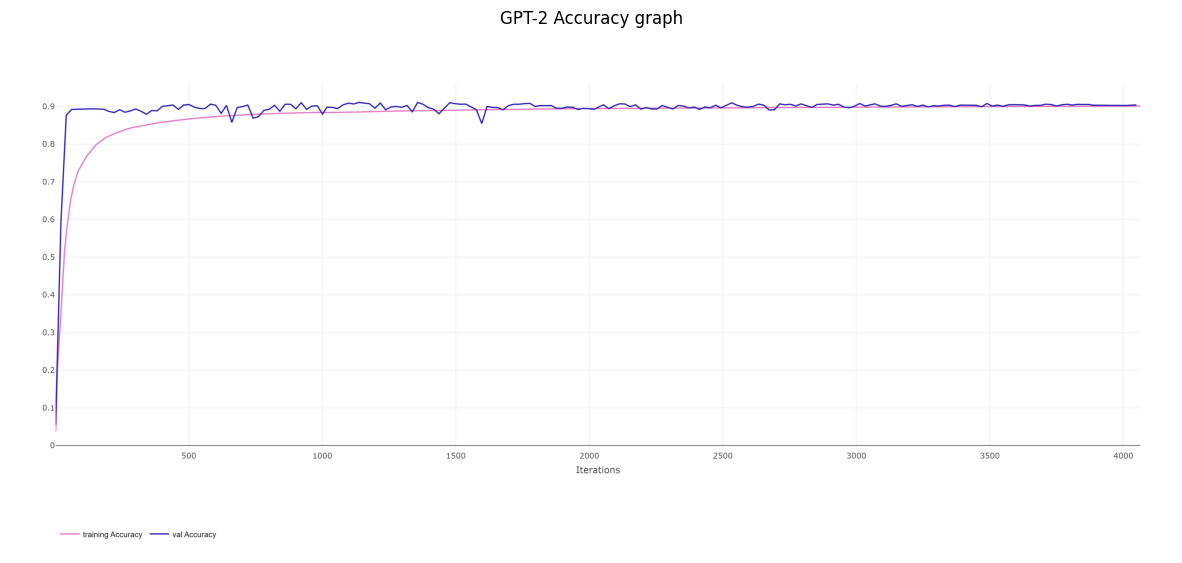

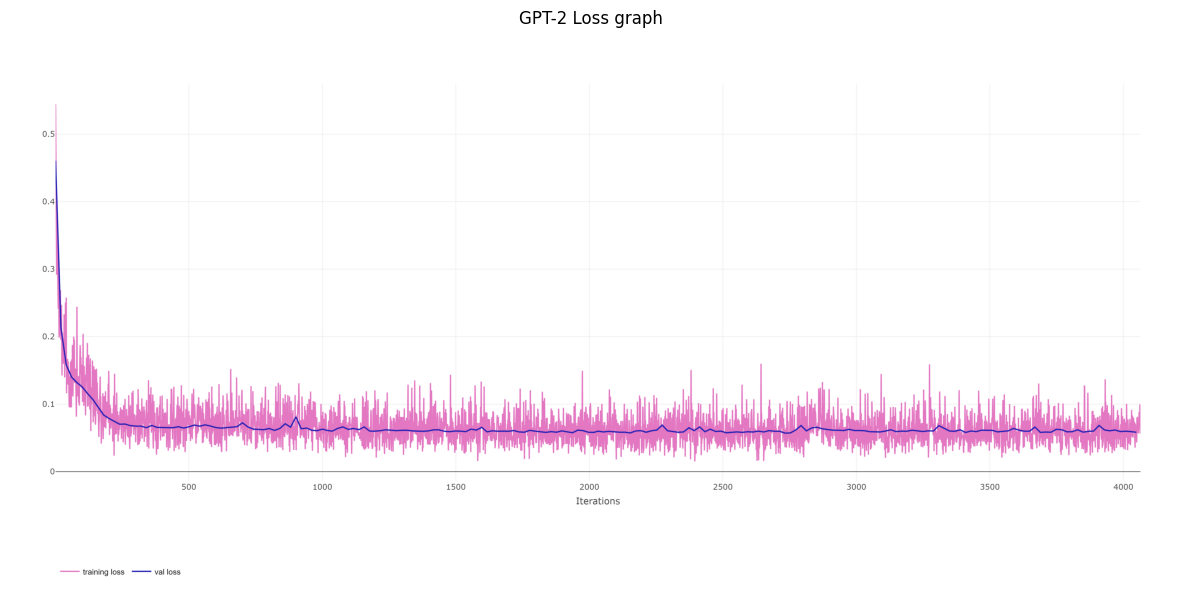

In [73]:
gpt2_acc_graph = plt.imread('gpt2 acc.png')
gpt2_loss_graph = plt.imread('gpt2 loss.png')

plt.figure(figsize=(15,20))
plt.imshow(gpt2_acc_graph)
plt.title('GPT-2 Accuracy graph')
plt.axis('off')

plt.figure(figsize=(15,20))
plt.imshow(gpt2_loss_graph)
plt.title('GPT-2 Loss graph')
f =plt.axis('off')

<font size="5">Test the model with the test dataset.</font><br>

In [70]:
gpt2_model.eval()
test(gpt2_model, gpt2_tokenizer, gpt2_test_dataloader, max_length=60)

Test process: 100%|██████████| 146/146 [00:20<00:00,  7.26it/s]

Test Accuracy: 0.905872031083537

Test AUC score: 0.9610818761871411

               precision    recall  f1-score   support

        toxic       0.75      0.74      0.74      1562
 severe_toxic       0.50      0.47      0.49       168
      obscene       0.78      0.72      0.75       875
       threat       0.00      0.00      0.00        33
       insult       0.67      0.66      0.67       804
identity_hate       0.50      0.01      0.01       133

    micro avg       0.73      0.67      0.70      3575
    macro avg       0.53      0.43      0.44      3575
 weighted avg       0.71      0.67      0.68      3575
  samples avg       0.06      0.06      0.06      3575



In [15]:
# save the model
path =  f'models/gpt2_model_{train_number}'
gpt2_model.save_pretrained(path, from_pt=True)